In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# load in the dataset
df_bills = pd.read_feather("117hrbills_encoded.feather")
df_bills

,bill_id,title,summary,sponsor_party,sponsor_state,sponsor_district,policy_area,subjects_count,introduced_date,passed_house
0,1,"[people, act, 2021]","[addresses, voter, access, election, integrity...",D,MD,3,Government Operations and Politics,113,0.000000,1
0,3,"[elijah, e, cummings, lower, drug, costs, act]","[establishes, several, programs, requirements,...",D,NJ,6,Health,47,0.148148,0
0,4,"[john, r, lewis, voting, rights, advancement, ...","[establishes, new, criteria, determining, stat...",D,AL,7,Government Operations and Politics,10,0.308642,1
0,5,"[equality, act]","[prohibits, discrimination, based, sex, sexual...",D,RI,1,"Civil Rights and Liberties, Minority Issues",15,0.061728,1
0,6,"[american, dream, promise, act, 2021]","[provides, certain, aliens, path, receive, per...",D,CA,40,Immigration,39,0.079561,1
...,...,...,...,...,...,...,...,...,...,...
0,9705,"[promoting, diverse, investment, advisers, act]","[requires, federal, reserve, board, set, goals...",D,OH,3,Finance and Financial Sector,1,1.000000,0
0,9706,"[ensuring, diverse, leadership, act, 2022]","[requires, appointing, president, federal, res...",D,OH,3,Finance and Financial Sector,1,1.000000,0
0,9707,"[mom, act]","[provides, block, grants, states, provide, chi...",R,TX,1,Families,1,1.000000,0
0,9708,"[fixing, administrations, unethical, corrupt, ...","[prohibits, specified, federal, officials, emp...",R,TX,1,Crime and Law Enforcement,1,1.000000,0


## One Hot Encoding Categorical Features

In [27]:
from sklearn.preprocessing import OneHotEncoder

In [30]:
categorical_features = df_bills[["sponsor_party", "sponsor_state", "sponsor_district", "policy_area"]]

# one hot encode categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_features = encoder.fit_transform(categorical_features)

In [34]:
encoded_categorical_features

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

## Tokenizing the Text

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input

In [8]:
summaries= [summary.tolist() for summary in df_bills["summary"]]
titles = [title.tolist() for title in df_bills["title"]]

# create the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(summaries + titles)

tokenized_summaries = tokenizer.texts_to_sequences(summaries)
tokenized_titles = tokenizer.texts_to_sequences(titles)

(array([7.880e+02, 2.441e+03, 1.777e+03, 1.296e+03, 8.670e+02, 6.810e+02,
        5.060e+02, 3.840e+02, 2.670e+02, 2.580e+02, 2.590e+02, 1.330e+02,
        2.500e+01, 6.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00]),
 array([  2. ,  15.8,  29.6,  43.4,  57.2,  71. ,  84.8,  98.6, 112.4,
        126.2, 140. , 153.8, 167.6, 181.4, 195.2, 209. , 222.8, 236.6,
        250.4, 264.2, 278. ]),
 <BarContainer object of 20 artists>)

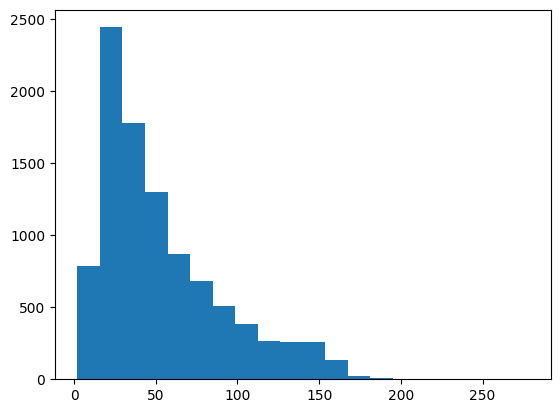

In [53]:
# plot histogram of summary word counts
plt.hist([len(i) for i in tokenized_summaries], bins=20)

(array([7.399e+03, 1.588e+03, 4.400e+02, 2.070e+02, 3.800e+01, 1.500e+01,
        7.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. , 35.8, 41.6, 47.4, 53.2, 59. ]),
 <BarContainer object of 10 artists>)

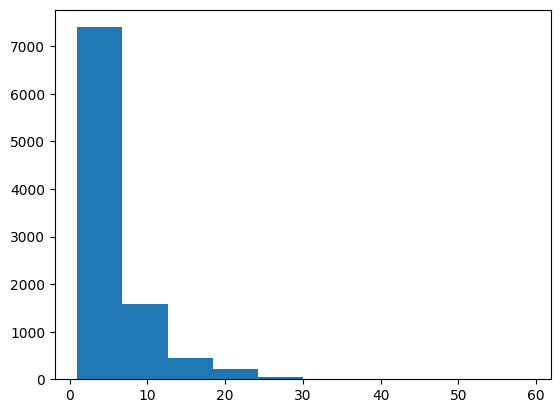

In [11]:
# plot histogram of title word counts
plt.hist([len(i) for i in tokenized_titles], bins=10)

In [12]:
# pad/truncate summaries to length 75 and titles to 10
max_summary_length = 75
max_title_length = 10

padded_summaries = pad_sequences(tokenized_summaries, 
                                 maxlen = max_summary_length, 
                                 padding = "post", 
                                 truncating = "post" , 
                                 value=0)

padded_titles = pad_sequences(tokenized_titles, 
                              maxlen = max_title_length, 
                              padding = "post", 
                              truncating = "post" , 
                              value=0)

In [38]:
# convert to numpy arrays
padded_summaries = np.array(padded_summaries)
padded_titles = np.array(padded_titles)

## Creating the Embedding Matrix
We're going to use pre-trained word vectors to create an embedding matrix for our text

In [14]:
from tqdm import tqdm

In [15]:
glove_file = "glove.42B.300d.txt"
embeddings_index = {}

with open(glove_file, "r", encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

1917495it [02:28, 12950.75it/s]


In [16]:
vocab_size = len(tokenizer.word_index) + 1  # add 1 because 0 is reserved for padding
embedding_dim = 300  # dimension of GloVe vectors

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Train Test Split and SMOTE

In [100]:
from sklearn.model_selection import train_test_split

In [101]:
# get the labels as a numpy array
labels = df_bills["passed_house"].to_numpy()

In [118]:
concatenated_input = np.concatenate([padded_summaries, padded_titles, encoded_categorical_features], axis=1)

# split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(concatenated_input, labels, test_size=0.2, random_state=42, stratify=labels)

# split up the training input
X_train_summaries = X_train[:, :padded_summaries.shape[1]]
X_train_titles = X_train[:, padded_summaries.shape[1]:padded_summaries.shape[1]+padded_titles.shape[1]]
X_train_categorical = X_train[:, -encoded_categorical_features.shape[1]:]

# split up the validation input
X_val_summaries = X_val[:, :padded_summaries.shape[1]]
X_val_titles = X_val[:, padded_summaries.shape[1]:padded_summaries.shape[1]+padded_titles.shape[1]]
X_val_categorical = X_val[:, -encoded_categorical_features.shape[1]:]

## Building the Model

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [126]:
model = Sequential()

# summary input and embedding layers
input_summaries = Input(shape=(max_summary_length,), name="input_summaries")
embedding_layer_summaries = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(input_summaries)
lstm_layer_summaries = LSTM(256)(embedding_layer_summaries)

# title input and embedding layers
input_titles = Input(shape=(max_title_length,), name="input_titles")
embedding_layer_titles = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(input_titles)
lstm_layer_titles = LSTM(128)(embedding_layer_titles)

# categorical features input layer
input_categorial = Input(shape=(encoded_categorical_features.shape[1],), name="categorical_input")

# combine lstm output with categorical features
combined_lstm = Concatenate()([lstm_layer_summaries, lstm_layer_titles])
combined_all = Concatenate()([combined_lstm, input_categorial])

# dense layers
x = Dense(128, activation='relu')(combined_all)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)


model = Model(inputs=[input_summaries, input_titles, input_categorial], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[ tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])

# Print model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_summaries     │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_titles        │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, 75, 300)   │  5,816,100 │ input_summaries[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 10, 300)   │  5,816,100 │ input_titles[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 256)       │    570,368 │ embedding_16[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 128)       │    219,648 │ embedding_17[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 384)       │          0 │ lstm_17[0][0],    │
│ (Concatenate)       │                   │            │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 145)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 529)       │          0 │ concatenate_14[0… │
│ (Concatenate)       │                   │            │ categorical_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     67,840 │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      8,256 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         65 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,498,377 (47.68 MB)

 Trainable params: 866,177 (3.30 MB)

 Non-trainable params: 11,632,200 (44.37 MB)

In [128]:
model.fit([X_train_summaries, X_train_titles, X_train_categorical], 
          y_train, 
          epochs=10, 
          batch_size=32, 
          validation_data=([X_val_summaries, X_val_titles, X_val_categorical], y_val),
          class_weight = {0: 1., 1: 10.})

Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 0.8968 - precision: 0.2196 - recall: 0.6339 - val_loss: 0.5221 - val_precision: 0.1767 - val_recall: 0.6897
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - loss: 0.7326 - precision: 0.2749 - recall: 0.7821 - val_loss: 0.5763 - val_precision: 0.1519 - val_recall: 0.7310
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - loss: 0.5533 - precision: 0.2998 - recall: 0.8473 - val_loss: 0.3445 - val_precision: 0.2430 - val_recall: 0.4759
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - loss: 0.3951 - precision: 0.4295 - recall: 0.9083 - val_loss: 0.3962 - val_precision: 0.2209 - val_recall: 0.5241
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - loss: 0.2767 - precision: 0.5098 - recall: 0.9581 - val_loss: 0.4163 - val_precision: 0.2323 - val_recall: 0.4966
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - loss: 0.2030 - precision: 0.5904 - recall: 0.9638 - val_loss: 0.4604 - val_precision: 0.2607 -

## Analysis

In [129]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [134]:
y_pred = model.predict([X_val_summaries, X_val_titles, X_val_categorical])
y_pred_classes = (y_pred > 0.5).astype(int)

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


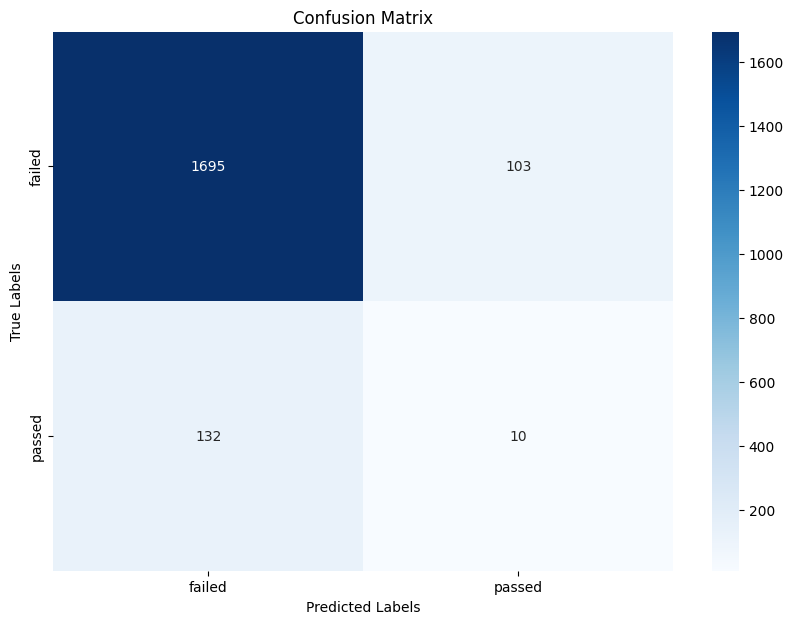

In [135]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["failed", "passed"],  # Adjust class labels as needed
            yticklabels=["failed", "passed"])  # Adjust class labels as needed
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()